# The distinct iterative prior updating process in ASD and TD individuals 

Research has shown individuals with autism spectrum disorder (ASD) display unique patterns in predictive processing, yet it remains controversial regarding what causes these atypical behaviors.  Both ASD individuals and typically developing (TD) counterparts participated in a task where they reproduced time durations over two sessions, one characterized by high volatility and the other by predictable sequence. Both sessions involved the same time durations, but the sequences differed in volatility. A visual stimulus (a disk) appeared for a given duration, and participants were asked to reproduce the duration by pressing a key.

This repository contains the data and analysis scripts for this study.   The codes and data are organized as follows:

## 1. Folder Structure

1. `/experiments`: Experimental codes and instructions

This sub-folder contains Matlab codes and instructions for the duration reproduction task. The sequences of the duration reproductions are stored in the sub-folder `/experiments/seqs`. Those sequences were used for matched participants. 

2. `/data`: raw data files

- `rawdata.csv`: Raw reproduction trials of all participants
- `parinfo.csv`: Participant information, including measured scores AQ, EQ, SQ, IQ etc. 

3. `/figures`: output figures. 
4. analysis scripts
- `analysis-notebook.ipynb`: Jupyter notebook for data analysis
- `kmodelY.py`: Python script for the Kalman filter two-state model
- 

## 2. Data Analysis

### 2.1 Import raw data

In [1]:
# load data analysis packages
%reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import least_squares
# pingouin ANOVA
import pingouin as pg
# keep output precision to 3 decimal places
pd.options.display.float_format = '{:,.3f}'.format

# read data from ./data/rawdata.csv
rawdata = pd.read_csv('./data/rawdata.csv')
# change rawdata.group to upper case
rawdata['group'] = rawdata['group'].str.upper()
# add a new column preErr, indicating the previous trial's error
rawdata['preErr'] = rawdata.groupby(['sub', 'Volatility'])['rep_err'].shift(1)
# mark the outliers that exceed [Duration/3, Duration * 3] or preErr is nan
rawdata['outlier'] = (rawdata['Reproduction'] < rawdata['Duration']/3) | (rawdata['Reproduction'] > rawdata['Duration']*3) | (rawdata['preErr'].isna())

# show the first 5 rows of rawdata
rawdata.head()



Nothing done.


Unnamed: 0  Duration Volatility  trlNo  blkNo  dur1  pdur  production  \
0           1     0.400  Low Vola.      1      1 0.400 0.400       0.409   
1           2     0.500  Low Vola.      2      1 0.500 0.506       0.507   
2           3     0.400  Low Vola.      3      1 0.400 0.400       0.406   
3           4     0.400  Low Vola.      4      1 0.400 0.400       0.397   
4           5     0.500  Low Vola.      5      1 0.500 0.506       0.501   

   vrep  Reproduction  sub group    itd  rep_err  sequence  preDuration  \
0 0.377         0.374  A31   ASD    NaN   -0.026        31          NaN   
1 0.353         0.342  A31   ASD  0.100   -0.158        31        0.400   
2 0.342         0.326  A31   ASD -0.100   -0.074        31        0.506   
3 0.412         0.406  A31   ASD  0.000    0.006        31        0.400   
4 0.412         0.398  A31   ASD  0.100   -0.102        31        0.400   

   blk1st     Order  preErr  outlier  
0       1  LV First     NaN     True  
1       0  LV First  -0.026    False  
2       0  LV First  -0.158    False  
3       0  LV First  -0.074    False  
4       0  LV First   0.006    False

The key columns in `rawdata.csv` are:
1. Duration: the duration of the visual stimulus
2. Reproduction: the reproduced duration
3. rep_err: the reproduction error (Reproduction - Duration)
4. preDuration: the duration of the previous visual stimulus
5. sub: subject ID
6. group: ASD or TD
7. Volatility: Low Vola. or High Vola.

The outlier trials were generally low for both groups: 2.3% for the ASD group and 1% for the TD group. 

In [2]:
# show the percentange of outliers in each group
rawdata.groupby(['sub', 'group'])['outlier'].mean().reset_index().groupby('group')['outlier'].mean()

group
ASD   0.023
TD    0.010
Name: outlier, dtype: float64

### 2.2 Duration sequences

The experiment was structured into two distinct sessions, characterized by high and low volatility respectively. Each session included 500 trials, all following the same distribution, yet they varied in terms of sequential volatility. The provided figure illustrates a typical sequence of durations for a single participant.


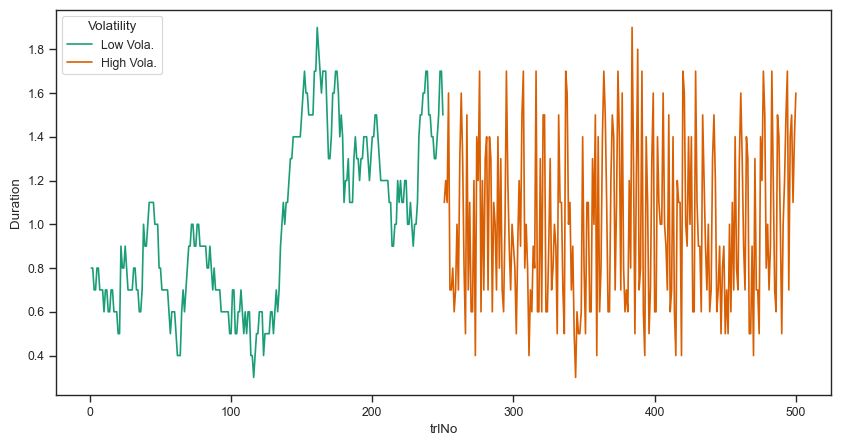

In [3]:
# sns 
sns.set(style='ticks', context='paper', rc={'figure.figsize': (10, 5)})
#sns.color_palette(palette='colorblind')
sns.set_palette("Dark2")

# select a subset of rawdata (sub == 'ara27') for illustration
subdata = rawdata.query('sub == "ara27"')
# plot Duration as a function of trlNo, using different color for Volatility
# use color palette 'colorblind' from seaborn
#sns.set_palette('colorblind')
sns.lineplot(x='trlNo', y='Duration', hue='Volatility', data=subdata)
plt.show()

### 2.3 Central tendency and autocorrelation


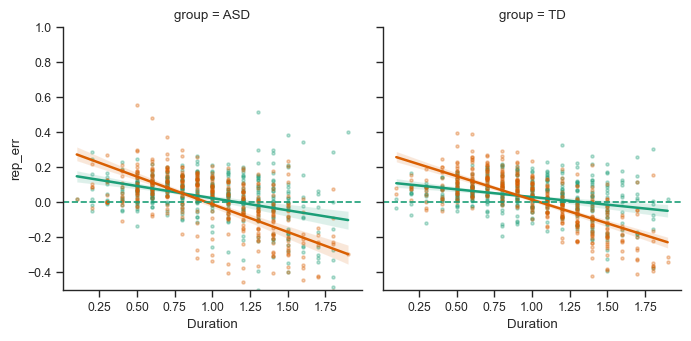

In [4]:
#  calculate the mean and standard deviation of Duration for each sub, group, Volatility, and Duration
mdata = rawdata.query('outlier == False').groupby(
    ['sub', 'group', 'Volatility', 'Duration','sequence','Order']).agg(
        {'rep_err': ['mean', 'std']}).reset_index()
mdata.columns = ['sub', 'group', 'Volatility', 'Duration', 'sequence','Order','rep_err', 'rep_err_std']

# visualize the mean reproduction error as a function of Duration
ax = sns.lmplot(x='Duration', y='rep_err', hue='Volatility', col='group', 
                scatter_kws = {'alpha':0.3, 's':5}, legend = False, height = 3.5, 
                data=mdata, hue_order = ['Low Vola.', 'High Vola.'])

# add dashed line 0 to each subplot
for ax1 in ax.axes.flat:
    ax1.axhline(0, ls='--')
plt.ylim(-0.5, 1.)
# save the figure to ./figures/rep_err_vs_Duration.png
plt.savefig('./figures/rep_err_vs_Duration_b.png', dpi=300)
plt.show()

In both group, the high volatility session showed a larger central tendency than the low volatility session. Let's do linear regression and durbin-watson test for the autocorrelation in two environments.

In [5]:
# define a regression function with input of a dataframe
from statsmodels.stats.stattools import durbin_watson
# define a regression function, input is a dataframe and y and x 
def reg_func(data, x='Duration'):
   # Check and remove NaNs or infinite values
    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=[x, 'rep_err'])
    
    if data.empty or data[x].isnull().any() or data['rep_err'].isnull().any():
        # Return None or some indication that the data was not valid for regression
        return pd.DataFrame({'r2': [None], 'intercept': [None], 'slope': [None],
            'cti': [None], 'ar_dw': [None], 'aic': [None]})

    reg = sm.OLS(data['rep_err'], sm.add_constant(data[x])).fit()
    dw = durbin_watson(reg.resid)
    aic = reg.aic
    # return goodness of fit, intercept, slope, and dw
    return pd.DataFrame({'r2': reg.rsquared, 'intercept': reg.params.iloc[0], 'slope':reg.params.iloc[1],
        'cti': -reg.params.iloc[1], 'ar_dw': dw, 'aic':reg.aic}, index=[0])
# apply the regression function to each sub, Volatility, and group
df_coef = rawdata.query('outlier == False').groupby(['sub', 'Volatility', 'sequence', 'group']).apply(reg_func).reset_index()
# show the first 5 rows of df_coef
df_coef.head()

sub  Volatility  sequence group  level_4    r2  intercept  slope   cti  \
0  A31  High Vola.        31   ASD        0 0.389      0.284 -0.451 0.451   
1  A31   Low Vola.        31   ASD        0 0.459      0.279 -0.506 0.506   
2  A32  High Vola.        32   ASD        0 0.606      0.550 -0.904 0.904   
3  A32   Low Vola.        32   ASD        0 0.020      0.222 -0.227 0.227   
4  A33  High Vola.        33   ASD        0 0.182      0.180 -0.239 0.239   

   ar_dw      aic  
0  1.710    9.836  
1  1.017   -4.688  
2  1.405  -86.745  
3  1.701  166.866  
4  1.783 -113.065

In [6]:
# Mixed ANOVA on the central tendency effect cti
# use pingouin to perform mixed ANOVA
aov = pg.mixed_anova(data=df_coef, dv='cti', within='Volatility', between='group', subject='sub')
# show the ANOVA table
aov

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.003    1   62 0.003  0.071  0.790 0.001   NaN
1   Volatility 1.611    1   62 1.611 80.105  0.000 0.564 1.000
2  Interaction 0.005    1   62 0.005  0.228  0.634 0.004   NaN

In [7]:
# Mixed ANOVA on the intercept
aov = pg.mixed_anova(data=df_coef, 
                     dv='intercept', within='Volatility', between='group', subject='sub')
# show the ANOVA table
aov

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.000    1   62 0.000  0.009  0.926 0.000   NaN
1   Volatility 1.370    1   62 1.370 84.976  0.000 0.578 1.000
2  Interaction 0.010    1   62 0.010  0.650  0.423 0.010   NaN

However, autoregressive durbins-watson test values were significant different between the two groups, even with the outliers. This suggests that we need to consider the inter-trial updating of the prior information.

In [8]:
pg.mixed_anova(data=df_coef, 
               dv='ar_dw', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.314    1   62 0.314 4.498  0.038 0.068   NaN
1   Volatility 0.059    1   62 0.059 2.142  0.148 0.033 1.000
2  Interaction 0.060    1   62 0.060 2.183  0.145 0.034   NaN

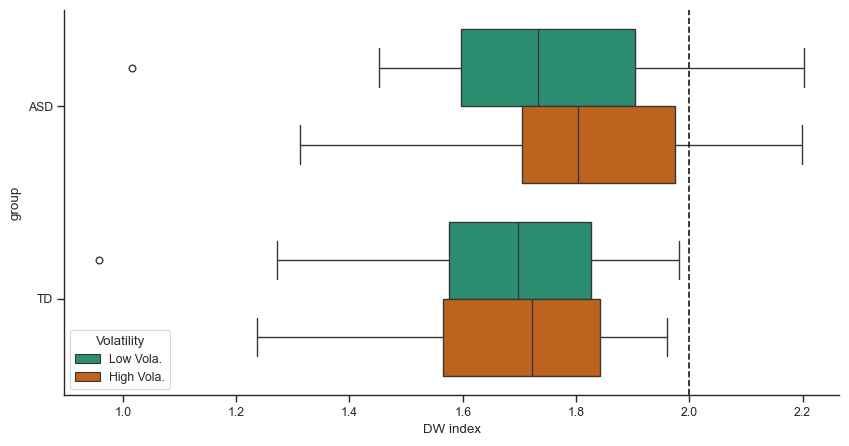

In [9]:
# plot mean and error bar of aw_dw as a function of group, Volatility
#sns.barplot(data=df_coef.query("sequence not in @outliers_regress"), 
#            x='group', y='ar_dw', hue='Volatility',capsize = .1,
#            zorder = 5, errorbar=('ci', 68))
# change y axis as 'DW index'
# y axis from 1 to 2
#plt.ylim(1, 2.4)
# add stripplot
sns.boxplot(data=df_coef, y='group', x='ar_dw', hue='Volatility', orient = 'h', hue_order=['Low Vola.', 'High Vola.'])
# only show the last two legends
handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(handles[2:], labels[2:])
# add dashed line 2 to indicate the 0 autocorrelation
plt.axvline(2, ls='--', c='k')
# remove box around the plot
sns.despine()
plt.xlabel('DW index')

# save the figure to vector file ./figures/ar_dw.pdf
plt.savefig('./figures/ar_dw.pdf', dpi=300)
# save the figure to ./figures/ar_dw.png
plt.savefig('./figures/ar_dw.png', dpi=300)
plt.show()



In [10]:
# let's compare if ar_dw was significantly lower than 2 in the two groups. 
# We will use a one-sample t-test to compare the mean of ar_dw to 2.
# t-test for ar_dw
pg.ttest(df_coef.query("group == 'ASD'")['ar_dw'], 2)


T  dof alternative  p-val         CI95%  cohen-d       BF10  power
T-test -7.913   63   two-sided  0.000  [1.72, 1.83]    0.989  1.893e+08  1.000

In [11]:
# for TD group
pg.ttest(df_coef.query("group == 'TD'")['ar_dw'], 2)

T  dof alternative  p-val         CI95%  cohen-d       BF10  \
T-test -11.877   63   two-sided  0.000  [1.62, 1.73]    1.485  5.748e+14   

        power  
T-test  1.000

## 2.4. Outliers 
There was no difference in cti between groups, partly because there were three outliers in the ASD groups, as the CTI > 0.9. 

In [12]:
df_coef.query("cti > 0.9")

sub  Volatility  sequence group  level_4    r2  intercept  slope   cti  \
2      A32  High Vola.        32   ASD        0 0.606      0.550 -0.904 0.904   
36  aril02  High Vola.         2   ASD        0 0.647      1.051 -0.997 0.997   
50   arm13  High Vola.        13   ASD        0 0.617      0.669 -0.907 0.907   

    ar_dw      aic  
2   1.405  -86.745  
36  1.313 -131.330  
50  1.650 -133.904

Let's visualize these three outliers. 

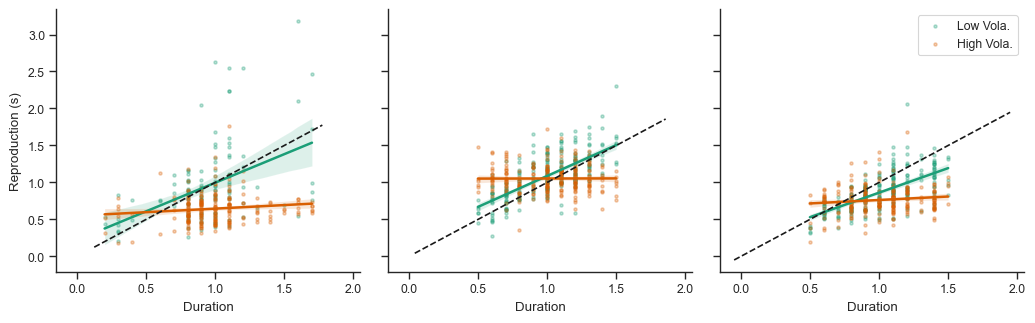

In [13]:
outliers_regress = df_coef.query("cti > 0.9").sequence
# from mdata, select rows with sequence in outliers_regress, and plot rep_err vs. Duration
# separate for individual sub, Volatility
moutliers = rawdata.query('sequence in @outliers_regress and group == "ASD" and outlier == False')
sns.set_palette('Dark2')
ax = sns.lmplot(x='Duration', y='Reproduction', hue='Volatility', col='sub',
                scatter_kws = {'alpha':0.3, 's':5}, legend = False, height = 3.5,
                data=moutliers)
ax.set(ylabel = 'Reproduction (s)')
# remove subplots titles
ax.set_titles('')
# add diagonal dashed line to each subplot
for ax in ax.axes.flat:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls='--', c='k')

# put legend in the upper right corner
plt.legend(loc='upper right')
# save the figure to ./figures/rep_err_vs_Duration_outliers.png
plt.savefig('./figures/outliers.png', dpi=300)
plt.savefig('./figures/outliers.pdf', dpi=300)
plt.show()


In [14]:
#Let's see what happens if we remove the outliers from the regression analysis.
# ANOVA for slopes with group as between-subject factor and Volatility as within-subject factor
pg.mixed_anova(data=df_coef.query("sequence not in @outliers_regress"), 
               dv='cti', within='Volatility', between = 'group', subject='sub')


Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.047    1   56 0.047  1.734  0.193 0.030   NaN
1   Volatility 1.204    1   56 1.204 81.366  0.000 0.592 1.000
2  Interaction 0.049    1   56 0.049  3.324  0.074 0.056   NaN

It remains not significant between groups, suggesting both groups had similar acquisition of the prior (Volatility) information. But let's check the residual autocorrelation.


In [15]:
pg.mixed_anova(data=df_coef.query("sequence not in @outliers_regress"), 
               dv='ar_dw', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.559    1   56 0.559 8.357  0.005 0.130   NaN
1   Volatility 0.087    1   56 0.087 3.338  0.073 0.056 1.000
2  Interaction 0.081    1   56 0.081 3.103  0.084 0.052   NaN

By excluding the outliers, the difference between groups became even more significant, p = .005. 

## 2.5 Visualize the behavioral results 


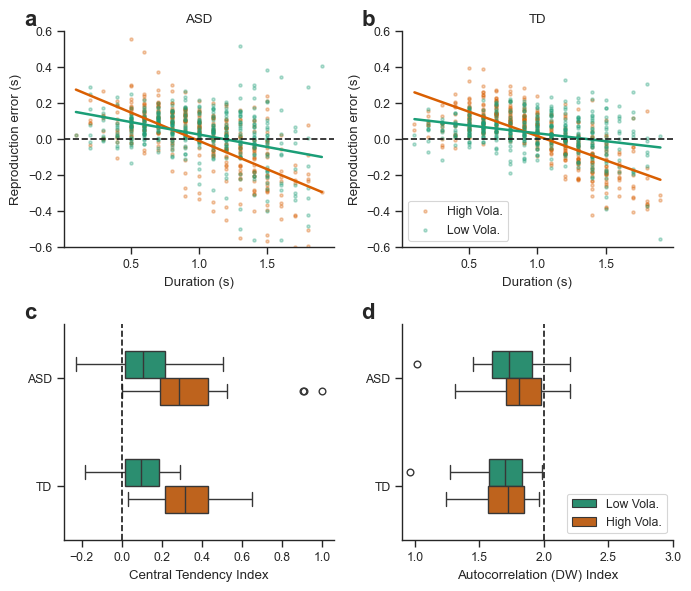

In [16]:
# now we combine plots together for the paper
sns.set(style='ticks', context='paper')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (7, 6))
sns.set_palette('Dark2')
# for each group, on seperate subplot, plot rep_err as a function of Duration, using different color for Volatility with regplot 
for i, group in enumerate(df_coef.group.unique()):
    for j, vol in enumerate(df_coef.Volatility.unique()):
        sns.regplot(data=mdata.query("group == @group and Volatility == @vol"), 
                    x='Duration', y='rep_err', ax = axes[0,i], color = sns.color_palette('Dark2')[1-j], label = vol, 
                    ci = None, scatter_kws = {'alpha':0.3, 's':5})
    if i == 1:
        axes[0,i].legend(loc='lower left')
    else:
        # remove legend
        axes[0,i].legend().remove()
    # add dashed line 0 to each subplot
    axes[0,i].axhline(0, ls='--', c='k')
    # set y axis limit
    axes[0,i].set_ylim(-0.6, 0.6)
    # set x label to 'Duration (s)', y label to 'Reproduction error (s)'
    axes[0,i].set(xlabel = 'Duration (s)', ylabel = 'Reproduction error (s)')
    # set title to group
    axes[0,i].set_title(group)
# add horizontal boxplot for cti from df_coef on the second row first column
sns.boxplot(data=df_coef, 
            y='group', x='cti', hue='Volatility', ax = axes[1,0],  width = 0.5, 
            orient = 'h', hue_order=['Low Vola.', 'High Vola.'])
axes[1,0].set(xlabel = 'Central Tendency Index')
axes[1,0].legend().remove()
# add a vertical line at 0.0
axes[1,0].axvline(0, ls='--', c='k')
# remove y axis label
axes[1,0].set(ylabel = '')
# add horizontal boxplot for ar_dw from df_coef on the second row second column
sns.boxplot(data=df_coef, y='group', x='ar_dw', hue='Volatility', width = 0.5, 
            ax = axes[1,1], orient = 'h', hue_order=['Low Vola.', 'High Vola.'])
# legend off
#axes[1,1].legend().remove()
axes[1,1].legend(loc='lower right')
axes[1,1].set(xlabel = 'Autocorrelation (DW) Index')
# add a vertical line at 2.0
axes[1,1].axvline(2, ls='--', c='k')
# x axis from 0.9 to 3
axes[1,1].set_xlim(0.9, 3)
axes[1,1].set(ylabel = '')
# remove box around the plot
sns.despine()
# add labels to subplots a, b, c, d
for i, label in enumerate(['a', 'b', 'c', 'd']):
    axes[int(i/2),i%2].text(-0.1, 1.1, label, transform=axes[int(i/2),i%2].transAxes, 
                            fontsize=16, fontweight='bold', va='top', ha='right')
    

# Adjust layout and show plot
plt.tight_layout()

# save fig to vector file ./figures/rep_err_vs_Duration.png
plt.savefig('./figures/rep_err_vs_Duration.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('./figures/rep_err_vs_Duration.pdf', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()


## 2.6 General bias (over- or under-reproduction) 


In [17]:
# average the reproduction errors for general biases
mrep_err = rawdata.query("outlier == False").groupby(['sub','group', 'Volatility'])['rep_err'].mean().reset_index()
# pingouin mixed ANOVA on mrep_err
aov = pg.mixed_anova(data=mrep_err, dv='rep_err', within='Volatility', between='group', subject='sub')
# show the ANOVA table
aov

Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.005    1   62 0.005 0.385  0.537 0.006   NaN
1   Volatility 0.010    1   62 0.010 5.573  0.021 0.082 1.000
2  Interaction 0.001    1   62 0.001 0.698  0.407 0.011   NaN

In [18]:
# calculate the mean reproduction error and standard deviation for each group and Volatility
mrep_err.groupby(['group'])['rep_err'].agg(['mean', 'std']).reset_index()

group  mean   std
0   ASD 0.024 0.099
1    TD 0.036 0.062

## 2.7 Two-state Iterative model



In [19]:
# include in one notebook (the following code from KmodelY.py)
from scipy.optimize import least_squares
from statsmodels.stats.stattools import durbin_watson
import numpy as np

def fitKmodel(subdata, nolog=None, pfit=None, p0=None):
    """
   Parameters:
    - subdata : subject data
    - nolog : If zero, logarithm is not used (default is 0)
    - pfit : A list of logical values to indicate which parameters to fit (default is [True, True, True])
    - p0 : Initial parameters (must always have length 3)
    
    Returns:
    - px : Parameters of the model

    By S.Glasauer 2019 (matlab), translated to Python by Strongway
    # add AIC and DW

    """
    
    # Handle default arguments
    if p0 is None:
        p0 = [1., 1, 0]
    if pfit is None:
        pfit = [True, True, True]
    if nolog is None:
        nolog = 0

    # Convert pfit to logical and filter p0
    pfit = np.array(pfit, dtype=bool)
    p0 = np.array(p0)[pfit]

    # Lower bounds (lb) for the optimization
    lb = np.array([0, 0, -np.inf])[pfit]
    

    # extract Duration and Reproduction from subdata as 2d array
    x = subdata['Duration'].values
    y = subdata['Reproduction'].values
    # replace extreme y with nan with y > 3 * x or y < x/3
    y[(y > 3 * x) | (y < x/3)] = np.nan
    # combine x,y as 2d array
    stimrep = np.vstack([x,y]).T
    # Perform the optimization using least_squares (equivalent to lsqnonlin in MATLAB)
    result = least_squares(kmodelY,  p0, args = (stimrep, 1),
                           bounds=(lb, np.inf), method='trf')
    
    # calculate kalmann filter parameters
    q11 = result.x[0]
    q22 = result.x[1]
    r = 1
    # calculate residual sum of squares
    rss = np.sum(result.fun**2)
    dw = durbin_watson(result.fun)
    # number of parameters
    k = len(result.x)
    # number of observations
    n = len(stimrep)
    # calculate the log-likelihood
    ll = -n/2*(np.log(2*np.pi) + np.log(rss/n) + 1)
    # calculate the Akaike information criterion (AIC)
    aic = 2*k - 2*ll
    # steady state solution
    p22 = (q22+np.sqrt(q22*q22+4*(q11+r)*q22))/2
    K = np.array([p22 + q11, p22])/(p22+q11+r)
    # return the optimized parameters, steady state solution, and AIC
    return np.append(np.append(result.x, K), [aic, dw])  # Optimized parameters


def kmodelY(par, stimrep, nolog=1, pfit=[1, 1, 1]):
    """
    Function to perform Kalman filter-based estimation.
    
    Parameters:
    - par: Model parameters (if pfit = [1,1,1], then par = [q1/r, q2/r, cost-related parameter (0 for median)])
    - stimrep: Stimulus representation
    - nolog: Flag to decide if logarithm transformation is needed
    - pfit: Parameter fitting list (note: len(par) = sum(pfit))
    
    Returns:
    - sres: Stimulus residuals
    - xest: Estimated state
    - pest: Estimate error covariance
    - resp: Response
    - perr: Prediction error

    S.Glasauer 2019/2023, translated to Python by Strongway
    """

    # Convert pfit to a boolean array
    pfit = np.array(pfit, dtype=bool)

    # Adjust pfit based on the size of par
    if len(par) < 3:
        pfit[len(par):] = False
    
    # Adjust stimrep's shape for further processing
    if stimrep.shape[1] == 1:
        stimrep = np.tile(stimrep, (1, 2))
    # the first column is the stimulus, the second column is the response, 
    # and add the third column to indicate the start of a new sequence
    #if stimrep.shape[1] == 2:
    #    stimrep = np.hstack((stimrep, np.zeros((stimrep.shape[0], 1))))
    #    stimrep[0, 2] = 1
    
    # Initialize pars and overwrite with provided parameters based on pfit
    pars = np.array([0.0, 0.0, 0.0])
    pars[pfit] = par
    par = pars

    # Constants for the model
    a = 10.0
    off = 1.
    r = 1.
    q1 = par[0] * r
    q2 = par[1] * r

    # Define matrices Q, P, H, and F for the Kalman filter of two-state model
    # details see Glasauer & Shi, 2022, Sci. Rep., https://doi.org/10.1038/s41598-022-14939-8
    Q = np.array([[q1, 0], [0, q2]])
    P = np.array([[r, 0], [0, r]])
    H = np.array([[1., 0]])
    F = np.array([[0, 1.], [0, 1.]])

    # Apply logarithm transformation if nolog is false
    if nolog:
        z = stimrep[:, 0]
    else: # log transformation
        z = np.log(a * stimrep[:, 0] + off)

    # Initialize state vector x
    x = np.array([[z[0]], [z[0]]])

    # Initialize matrices for storing results
    xest = np.zeros((len(z), 2))
    pest = np.zeros((len(z), 2))
    perr = np.zeros(len(z))

    # Kalman filter estimation loop
    for i in range(len(z)):
        
        x = F@x
        P = F@P@F.T + Q
        K = P@H.T/(H@P@H.T + r)
        perr[i] = z[i] - H@x
        x = x + K*perr[i]
        P = (np.eye(2) - K@H)@P

        pest[i, :] = np.diag(P)
        xest[i, :] = x.reshape(-1)

    # Adjust for third parameter, if present
    if len(par) == 3:
        sh = par[2]
    else:
        sh = 0

    # Compute response, adjusting for logarithm if needed
    if nolog:
        resp = xest[:, 0] + sh
    else: # log transformation
        resp = (np.exp(xest[:, 0] + sh) - off)/a 
        

    # Calculate stimulus residuals
    sres = stimrep[:, 1] - resp

    # Remove NaNs from sres
    sres = sres[np.isfinite(sres)]

    return sres


In [20]:
# fit two-state model
# from kmodelY import * #(when use kmodelY.py)

# fit two-state model
# subsecting each subject, volatility, and estimate two-state model parameters
df_kmodel = rawdata.groupby(
    ['sub', 'Volatility', 'sequence', 'group']).apply(
        fitKmodel).reset_index()
df_kmodel.columns = ['sub', 'Volatility', 'sequence', 'group', 'par']
# split the parameters to columns
df_kmodel[['p1','p2','tau','K1', 'K2','AIC_2S','DW_2S']] = pd.DataFrame(df_kmodel['par'].tolist(), index=df_kmodel.index)
# add a column for the difference between K1 and K2
df_kmodel['Kd'] = df_kmodel['K2'] - df_kmodel['K1']
# sequential dependence analytical results for randomized sequences
df_kmodel['kseq'] = df_kmodel['K2']*(1-df_kmodel['K1'])
df_kmodel.head()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_88937/1675682148.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  perr[i] = z[i] - H@x


sub  Volatility  sequence group  \
0  A31  High Vola.        31   ASD   
1  A31   Low Vola.        31   ASD   
2  A32  High Vola.        32   ASD   
3  A32   Low Vola.        32   ASD   
4  A33  High Vola.        33   ASD   

                                                 par    p1    p2    tau    K1  \
0  [0.9185124640252414, 0.05243938464301662, -0.1... 0.919 0.052 -0.170 0.558   
1  [0.7563162466196017, 2.049556565459247e-05, -0... 0.756 0.000 -0.290 0.433   
2  [0.09834201160694395, 1.1492562435182896e-18, ... 0.098 0.000 -0.330 0.090   
3  [3.342491279429646e-10, 0.4012756813450186, -0... 0.000 0.401 -0.001 0.464   
4  [1.0307068777913497, 1.3110276998645982, -0.06... 1.031 1.311 -0.061 0.775   

     K2   AIC_2S  DW_2S     Kd  kseq  
0 0.152   -1.177  1.728 -0.406 0.067  
1 0.003  -42.879  1.181 -0.429 0.002  
2 0.000 -132.762  1.382 -0.090 0.000  
3 0.464  158.794  1.669 -0.000 0.249  
4 0.543 -134.099  1.838 -0.232 0.122

In [21]:
# combine df_kmodel and df_seq by sub, Volatility, and group
kpars = df_kmodel.merge(df_coef, on=['sub', 'Volatility', 'sequence', 'group'])
# show the first 5 rows of df_kmodel
kpars['dAIC'] = kpars['AIC_2S'] - kpars['aic']
kpars.head()

sub  Volatility  sequence group  \
0  A31  High Vola.        31   ASD   
1  A31   Low Vola.        31   ASD   
2  A32  High Vola.        32   ASD   
3  A32   Low Vola.        32   ASD   
4  A33  High Vola.        33   ASD   

                                                 par    p1    p2    tau    K1  \
0  [0.9185124640252414, 0.05243938464301662, -0.1... 0.919 0.052 -0.170 0.558   
1  [0.7563162466196017, 2.049556565459247e-05, -0... 0.756 0.000 -0.290 0.433   
2  [0.09834201160694395, 1.1492562435182896e-18, ... 0.098 0.000 -0.330 0.090   
3  [3.342491279429646e-10, 0.4012756813450186, -0... 0.000 0.401 -0.001 0.464   
4  [1.0307068777913497, 1.3110276998645982, -0.06... 1.031 1.311 -0.061 0.775   

     K2  ...     Kd  kseq  level_4    r2  intercept  slope   cti  ar_dw  \
0 0.152  ... -0.406 0.067        0 0.389      0.284 -0.451 0.451  1.710   
1 0.003  ... -0.429 0.002        0 0.459      0.279 -0.506 0.506  1.017   
2 0.000  ... -0.090 0.000        0 0.606      0.550 -0.904 0.904  1.405   
3 0.464  ... -0.000 0.249        0 0.020      0.222 -0.227 0.227  1.701   
4 0.543  ... -0.232 0.122        0 0.182      0.180 -0.239 0.239  1.783   

       aic    dAIC  
0    9.836 -11.013  
1   -4.688 -38.192  
2  -86.745 -46.017  
3  166.866  -8.072  
4 -113.065 -21.033  

[5 rows x 22 columns]

In [22]:
# mean benefits of two-state model in terms of AIC
kpars['dAIC'].mean()

-10.75263200035032

the AIC difference between the two models was significant, suggesting the two-state model was a better fit to the data.

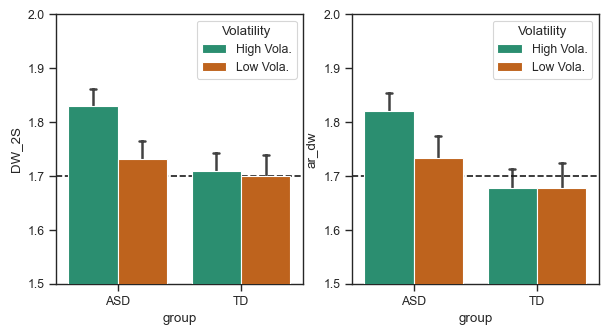

In [23]:
fig, axes = plt.subplots(ncols = 2, figsize = (7, 3.5))
# barplot for DW_2S as a function of group, Volatility
sns.barplot(data=kpars, x='group', y='DW_2S', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('ci', 68), ax = axes[0])
# change y axis to 1.5 to 2
axes[0].set_ylim(1.5, 2)
# add dashed line 2 to indicate the 0 autocorrelation
axes[0].axhline(2, ls='--', c='k')
axes[0].axhline(1.7, ls='--', c='k')
# second subplot for the ar_dw as a function of group, Volatility
sns.barplot(data=kpars, x='group', y='ar_dw', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('ci', 68), ax = axes[1])
# change y axis to 1.5 to 2
axes[1].set_ylim(1.5, 2)
# add dashed line 2 to indicate the 0 autocorrelation
axes[1].axhline(2, ls='--', c='k')
axes[1].axhline(1.7, ls='--', c='k')

In [24]:

# average K1, K2, and tau for each Volatility, group, with standard error
df_kmodel.groupby(['group', 'Volatility']).agg({'K1': ['mean', 'sem'], 'K2': ['mean', 'sem'], 'kseq': ['mean', 'sem'], 'tau': ['mean', 'sem']})

# save kmodel_v to csv file ./data/kmodel_v.csv
#kmodel_v.to_csv('./data/kmodel_v.csv', index=False)

K1          K2        kseq         tau      
                  mean   sem  mean   sem  mean   sem  mean   sem
group Volatility                                                
ASD   High Vola. 0.681 0.043 0.446 0.047 0.100 0.013 0.013 0.019
      Low Vola.  0.642 0.036 0.344 0.057 0.089 0.016 0.041 0.017
TD    High Vola. 0.682 0.026 0.396 0.039 0.113 0.012 0.031 0.010
      Low Vola.  0.568 0.035 0.198 0.038 0.088 0.016 0.057 0.010

### Statistics for those parameters

In [25]:
# statistics for K1
pg.mixed_anova(data=df_kmodel, dv='K1', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.043    1   62 0.043  0.685  0.411 0.011   NaN
1   Volatility 0.188    1   62 0.188 10.613  0.002 0.146 1.000
2  Interaction 0.046    1   62 0.046  2.620  0.111 0.041   NaN

In [26]:
# statistics for K2
pg.mixed_anova(data=df_kmodel, dv='K2', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.307    1   62 0.307  4.232  0.044 0.064   NaN
1   Volatility 0.725    1   62 0.725 11.754  0.001 0.159 1.000
2  Interaction 0.075    1   62 0.075  1.209  0.276 0.019   NaN

K2 shows a significant difference between groups!

In [27]:
# statistics for tau
pg.mixed_anova(data=df_kmodel, dv='tau', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.009    1   62 0.009  0.794  0.376 0.013   NaN
1   Volatility 0.024    1   62 0.024 11.835  0.001 0.160 1.000
2  Interaction 0.000    1   62 0.000  0.013  0.911 0.000   NaN

In [28]:
# exclude outliers
kmodel_v = df_kmodel.query("sequence not in @outliers_regress")
#kmodel_v = df_kmodel

### Visualize the parameters

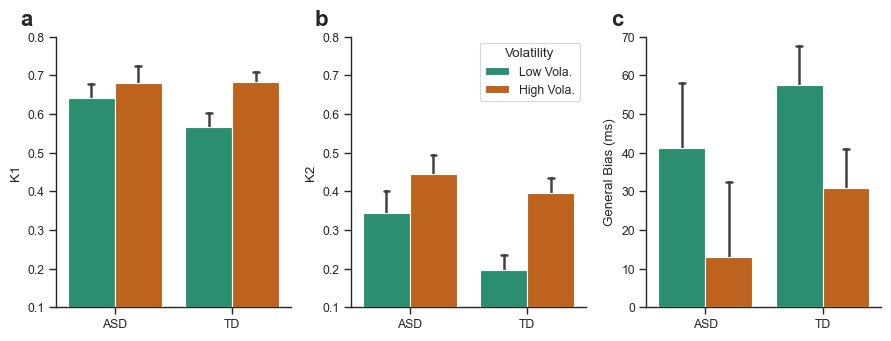

In [29]:
# visualize the mean and standard error of K1, K2, and tau as a function of group, Volatility
sns.set(style='ticks', context='paper')
sns.set_palette('Dark2')

# three subplots side by side
fig, axes = plt.subplots(ncols = 3, figsize = (9, 3.5))
# barplot for K1 as a function of group, Volatility
sns.barplot(data=df_kmodel, x='group', y='K1', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('se'), ax = axes[0], hue_order=['Low Vola.', 'High Vola.'])
# y axis from 0.5 to 1
axes[0].set_ylim(0.1, .8)
# legend top right
axes[0].legend(loc='upper right')
axes[0].legend().remove()
# remove x axis label
axes[0].set(xlabel = '')
# barplot for K2 as a function of group, Volatility
sns.barplot(data=df_kmodel, x='group', y='K2', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('se'), ax = axes[1], hue_order=['Low Vola.', 'High Vola.'])
# legend off
#axes[1].legend().remove()
axes[1].set_ylim(0.1, .8)
axes[1].set(xlabel = '')

# barplot for tau as a function of group, Volatility
# change the tau from seconds to milliseconds
df_kmodel['Tau'] = df_kmodel['tau']*1000
sns.barplot(data=df_kmodel, x='group', y='Tau', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('se'), ax = axes[2], hue_order=['Low Vola.', 'High Vola.'])
# y label to 'tau (ms)'
axes[2].set_ylabel('General Bias (ms)')
# legend off
axes[2].legend().remove()
axes[2].set(xlabel = '')
axes[2].set_ylim(0, 70)

# remove box around the plot
sns.despine()
# add labels to subplots a, b, c, d
for i, label in enumerate(['a', 'b', 'c']):
    axes[i].text(-0.1, 1.1, label, transform=axes[i].transAxes, 
                            fontsize=16, fontweight='bold', va='top', ha='right')
# tight layout
plt.tight_layout()

# save the figure to vector file ./figures/kmodel.png
plt.savefig('./figures/kmodel.png', dpi=300)
plt.savefig('./figures/kmodel.pdf', dpi=300)


In [30]:
# display those outliers parameters
df_kmodel.groupby(['group', 'Volatility']).agg({'K1': ['mean', 'sem'], 'K2': ['mean', 'sem'], 'kseq': ['mean', 'sem'], 'tau': ['mean', 'sem']})


K1          K2        kseq         tau      
                  mean   sem  mean   sem  mean   sem  mean   sem
group Volatility                                                
ASD   High Vola. 0.681 0.043 0.446 0.047 0.100 0.013 0.013 0.019
      Low Vola.  0.642 0.036 0.344 0.057 0.089 0.016 0.041 0.017
TD    High Vola. 0.682 0.026 0.396 0.039 0.113 0.012 0.031 0.010
      Low Vola.  0.568 0.035 0.198 0.038 0.088 0.016 0.057 0.010

## 2.8 Would large K2 lead to a slow updating?



Given that K2 was significantly larger in the ASD group, we would expect a slower updating of the prior information. So we split the trials into two: the first half and the second half. Due to reduction of the sample trials, we excluded the outliers in this analysis.

In [31]:
# let's check the first half of the trials from each session from the rawdata
# select the first half of the trials (trlNo 1-125 for the first session, 251-375 for the second) 
firsthalf_raw = rawdata.query('trlNo <= 125 or (trlNo >= 251 and trlNo <= 375)')
# and second half of the trials (trlNo 126-250 for the first session, 376-500 for the second)
secondhalf_raw = rawdata.query('trlNo >= 126 or trlNo >= 376')
# calculate coefficient for the first half of the trials
df_coef1 = firsthalf_raw.query('outlier == False and sequence not in @outliers_regress').groupby(['sub', 'Volatility', 'sequence', 'group']).apply(reg_func).reset_index()
# calculate coefficient for the second half of the trials
df_coef2 = secondhalf_raw.query('outlier == False and sequence not in @outliers_regress').groupby(['sub', 'Volatility', 'sequence', 'group']).apply(reg_func).reset_index()


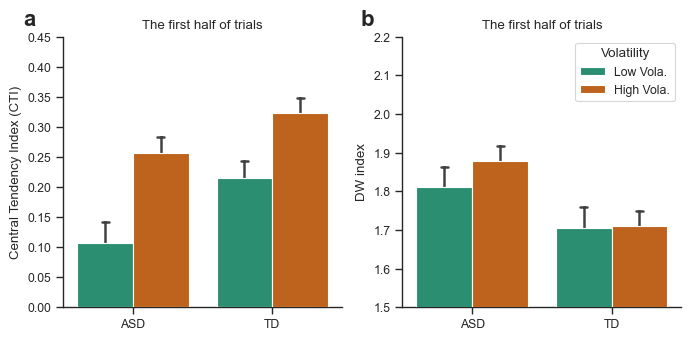

In [32]:

sns.set(style='ticks', context='paper')
sns.set_palette('Dark2')
# two subplots side by side
fig, axes = plt.subplots(ncols = 2, figsize = (7, 3.5))
# barplot for cti as a function of group, Volatility, and half
sns.barplot(data=df_coef1, x='group', y='cti', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('ci', 68), ax = axes[0], hue_order=['Low Vola.', 'High Vola.'])
axes[0].set_ylim(0, 0.45)
# legend off
axes[0].legend().remove()
# remove x axis label
axes[0].set(xlabel = '')
axes[0].set(ylabel = 'Central Tendency Index (CTI)')
# add title to the subplot
axes[0].set_title('The first half of trials')
# second subplot for the ar_dw as a function of group, Volatility, and half
sns.barplot(data=df_coef1, x='group', y='ar_dw', hue='Volatility', capsize = .1,
            zorder = 5, errorbar=('ci', 68), ax = axes[1], hue_order=['Low Vola.', 'High Vola.'])
axes[1].set(xlabel = '')
axes[1].set(ylabel = 'DW index')
# y axis from 1.5 to 2.5
axes[1].set_ylim(1.5, 2.2)
# add dashed line 2 to indicate the 0 autocorrelation
#axes[1].axhline(2, ls='--', c='k')
axes[1].set_title('The first half of trials')
# add title to the subplot
#axes[1].set_title('Changes in CTI')
# remove box around the plot
sns.despine()
# add labels to subplots a, b, c, d
for i, label in enumerate(['a', 'b']):
    axes[i].text(-0.1, 1.1, label, transform=axes[i].transAxes, 
                            fontsize=16, fontweight='bold', va='top', ha='right')
# tight layout
plt.tight_layout()
# save the figure to vector file ./figures/cti_half.png
plt.savefig('./figures/cti_half.png', dpi=300)
plt.savefig('./figures/cti_half.pdf', dpi=300)


In [33]:
pg.mixed_anova(data=df_coef1, 
               dv='cti', within='Volatility', between = 'group', subject='sub')


Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.222    1   56 0.222  6.236  0.015 0.100   NaN
1   Volatility 0.480    1   56 0.480 24.738  0.000 0.306 1.000
2  Interaction 0.013    1   56 0.013  0.682  0.412 0.012   NaN

The above statistics showed that the central tendency was significantly difference between groups in the first half! This suggests that the ASD group had a slower updating of the prior information, which might not have fully updated in the first half.

In [34]:
pg.mixed_anova(data=df_coef1, 
               dv='ar_dw', within='Volatility', between = 'group', subject='sub')


Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.544    1   56 0.544 7.202  0.010 0.114   NaN
1   Volatility 0.036    1   56 0.036 0.694  0.408 0.012 1.000
2  Interaction 0.027    1   56 0.027 0.522  0.473 0.009   NaN

the autocorrelation index (DW) for the first half of the trials was also significant between two groups. 

Compared to the entire sessions: 

In [35]:
pg.mixed_anova(data=df_coef.query("sequence not in @outliers_regress"), 
               dv='cti', within='Volatility', between = 'group', subject='sub')


Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.047    1   56 0.047  1.734  0.193 0.030   NaN
1   Volatility 1.204    1   56 1.204 81.366  0.000 0.592 1.000
2  Interaction 0.049    1   56 0.049  3.324  0.074 0.056   NaN

In [36]:
pg.mixed_anova(data=df_coef.query("sequence not in @outliers_regress"), 
               dv='ar_dw', within='Volatility', between = 'group', subject='sub')


Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.559    1   56 0.559 8.357  0.005 0.130   NaN
1   Volatility 0.087    1   56 0.087 3.338  0.073 0.056 1.000
2  Interaction 0.081    1   56 0.081 3.103  0.084 0.052   NaN

### Fit the two-state model to the first half of the trials

In [37]:
# now fit two-state model to the first half of the trials
# subsecting each subject, volatility, and estimate two-state model parameters
df_kmodel1 = firsthalf_raw.query("sequence not in @outliers_regress").groupby(
    ['sub', 'Volatility', 'sequence', 'group']).apply(
        fitKmodel).reset_index()
df_kmodel1.columns = ['sub', 'Volatility', 'sequence', 'group', 'par']
# split the parameters to columns
df_kmodel1[['p1','p2','tau','K1', 'K2','AIC_2S','DW_2S']] = pd.DataFrame(df_kmodel1['par'].tolist(), 
                                                                         index=df_kmodel1.index)
df_kmodel1.head()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_88937/1675682148.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  perr[i] = z[i] - H@x


sub  Volatility  sequence group  \
0  A31  High Vola.        31   ASD   
1  A31   Low Vola.        31   ASD   
2  A33  High Vola.        33   ASD   
3  A33   Low Vola.        33   ASD   
4  A34  High Vola.        34   ASD   

                                                 par    p1     p2    tau  \
0  [0.9714549830363363, 0.01693385718297349, -0.1... 0.971  0.017 -0.199   
1  [2.0532000286870844e-22, 12.169718779060531, -... 0.000 12.170 -0.438   
2  [1.204485814584274, 0.7122651732928083, -0.058... 1.204  0.712 -0.058   
3  [5.735340853415004e-12, 0.4293106313521714, -0... 0.000  0.429 -0.028   
4  [0.06397846678007811, 0.4849299971316463, 0.00... 0.064  0.485  0.005   

     K1    K2   AIC_2S  DW_2S  
0 0.538 0.088   -7.870  1.933  
1 0.929 0.929   66.842  0.850  
2 0.741 0.429  -60.205  1.666  
3 0.475 0.475 -117.713  2.117  
4 0.516 0.485 -133.310  1.814

In [38]:
# show the average K1, K2 and tau for each group and Volatility
df_kmodel1.groupby(['group', 'Volatility']).agg({'K1': ['mean', 'sem'], 'K2': ['mean', 'sem'], 'tau': ['mean', 'sem']})


K1          K2         tau      
                  mean   sem  mean   sem  mean   sem
group Volatility                                    
ASD   High Vola. 0.750 0.029 0.466 0.057 0.028 0.016
      Low Vola.  0.610 0.046 0.333 0.058 0.034 0.022
TD    High Vola. 0.685 0.026 0.396 0.048 0.012 0.011
      Low Vola.  0.554 0.042 0.178 0.047 0.052 0.013

In [59]:
# Fit the second half of the trials
df_kmodel2 = secondhalf_raw.query("sequence not in @outliers_regress").groupby(
    ['sub', 'Volatility', 'sequence', 'group']).apply(
        fitKmodel).reset_index()
df_kmodel2.columns = ['sub', 'Volatility', 'sequence', 'group', 'par']
# split the parameters to columns
df_kmodel2[['p1','p2','tau','K1', 'K2','AIC_2S','DW_2S']] = pd.DataFrame(df_kmodel2['par'].tolist(), 
                                                                         index=df_kmodel2.index)
df_kmodel2.head()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_88937/1675682148.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  perr[i] = z[i] - H@x


sub  Volatility  sequence group  \
0  A31  High Vola.        31   ASD   
1  A31   Low Vola.        31   ASD   
2  A33  High Vola.        33   ASD   
3  A33   Low Vola.        33   ASD   
4  A34  High Vola.        34   ASD   

                                                 par    p1    p2    tau    K1  \
0  [0.9185124640252414, 0.05243938464301662, -0.1... 0.919 0.052 -0.170 0.558   
1  [1.511976006043292, 0.5687978606678477, -0.024... 1.512 0.569 -0.025 0.752   
2  [1.0307068777913497, 1.3110276998645982, -0.06... 1.031 1.311 -0.061 0.775   
3  [1.9645484931303274, 0.18705402981725533, -0.0... 1.965 0.187 -0.045 0.737   
4  [0.25349416480762293, 0.40788636070138073, -0.... 0.253 0.408 -0.020 0.546   

     K2   AIC_2S  DW_2S  
0 0.152   -1.177  1.728  
1 0.376 -112.774  1.116  
2 0.543 -134.099  1.838  
3 0.222  -86.835  1.842  
4 0.430 -272.994  1.652

In [60]:
df_kmodel2.groupby(['group', 'Volatility']).agg({'K1': ['mean', 'sem'], 'K2': ['mean', 'sem'], 'tau': ['mean', 'sem']})


K1          K2         tau      
                  mean   sem  mean   sem  mean   sem
group Volatility                                    
ASD   High Vola. 0.728 0.028 0.482 0.044 0.038 0.015
      Low Vola.  0.673 0.034 0.360 0.059 0.057 0.014
TD    High Vola. 0.655 0.027 0.385 0.036 0.044 0.013
      Low Vola.  0.576 0.036 0.267 0.044 0.060 0.012

In [39]:
# compared to df_kmodel
df_kmodel.groupby(['group', 'Volatility']).agg({'K1': ['mean', 'sem'], 'K2': ['mean', 'sem'], 'tau': ['mean', 'sem']})

K1          K2         tau      
                  mean   sem  mean   sem  mean   sem
group Volatility                                    
ASD   High Vola. 0.681 0.043 0.446 0.047 0.013 0.019
      Low Vola.  0.642 0.036 0.344 0.057 0.041 0.017
TD    High Vola. 0.682 0.026 0.396 0.039 0.031 0.010
      Low Vola.  0.568 0.035 0.198 0.038 0.057 0.010

In [61]:
# combine df_kmodel2 and df_kmodel1 by sub, Volatility, and group, for K1, K2, and tau, and add differences between two 
# K1, K2, and tau
kmodel_v1 = df_kmodel1.merge(df_kmodel2, on=['sub', 'Volatility', 'sequence', 'group'])
kmodel_v1['dK1'] = kmodel_v1['K1_x'] - kmodel_v1['K1_y']
kmodel_v1['dK2'] = kmodel_v1['K2_x'] - kmodel_v1['K2_y']
kmodel_v1['dtau'] = kmodel_v1['tau_x'] - kmodel_v1['tau_y']
# show the average dk1, dk2, and dtau for each group and Volatility
kmodel_v1.groupby(['group', 'Volatility']).agg({'dK1': ['mean', 'sem'], 'dK2': ['mean', 'sem'], 'dtau': ['mean', 'sem']})

dK1          dK2         dtau      
                   mean   sem   mean   sem   mean   sem
group Volatility                                       
ASD   High Vola.  0.022 0.015 -0.017 0.057 -0.010 0.008
      Low Vola.  -0.063 0.038 -0.027 0.065 -0.023 0.017
TD    High Vola.  0.031 0.015  0.011 0.051 -0.032 0.011
      Low Vola.  -0.022 0.035 -0.089 0.060 -0.008 0.010

In [62]:
# anova test for dK1
pg.mixed_anova(data=kmodel_v1, 
               dv='dK1', within='Volatility', between = 'group', subject='sub')


Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.018    1   56 0.018 0.751  0.390 0.013   NaN
1   Volatility 0.136    1   56 0.136 6.182  0.016 0.099 1.000
2  Interaction 0.007    1   56 0.007 0.331  0.567 0.006   NaN

In [63]:
# show the average dk1, dk2, and dtau for each group and Volatility
kmodel_v1.groupby([ 'Volatility']).agg({'dK1': ['mean', 'sem'], 'dK2': ['mean', 'sem'], 'dtau': ['mean', 'sem']})

dK1          dK2         dtau      
             mean   sem   mean   sem   mean   sem
Volatility                                       
High Vola.  0.026 0.011 -0.003 0.038 -0.021 0.007
Low Vola.  -0.042 0.026 -0.058 0.044 -0.016 0.010

In [42]:
pg.mixed_anova(data=df_kmodel1, 
               dv='K1', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.105    1   56 0.105  1.914  0.172 0.033   NaN
1   Volatility 0.532    1   56 0.532 21.887  0.000 0.281 1.000
2  Interaction 0.001    1   56 0.001  0.021  0.885 0.000   NaN

In [64]:
# anova test for dK2
pg.mixed_anova(data=kmodel_v1, 
               dv='dK2', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.009    1   56 0.009 0.077  0.782 0.001   NaN
1   Volatility 0.089    1   56 0.089 1.107  0.297 0.019 1.000
2  Interaction 0.059    1   56 0.059 0.736  0.395 0.013   NaN

In [67]:
# anova test for dK1
pg.mixed_anova(data=df_kmodel1, 
               dv='K2', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.369    1   56 0.369  4.514  0.038 0.075   NaN
1   Volatility 0.893    1   56 0.893 11.179  0.001 0.166 1.000
2  Interaction 0.053    1   56 0.053  0.661  0.420 0.012   NaN

In [45]:
# anova test for dtau
pg.mixed_anova(data=kmodel_v1, 
               dv='dtau', within='Volatility', between = 'group', subject='sub')

Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.000    1   56 0.000 0.217  0.643 0.004   NaN
1   Volatility 0.000    1   56 0.000 0.078  0.781 0.001 1.000
2  Interaction 0.003    1   56 0.003 1.626  0.208 0.028   NaN

## 2.9 General Linear Model with the current and previous trial durations

Given that the low-volatility session used the random walk sequence, the current and previous durations were highly correlated. So we use the difference between the current and previous durations as a regressor. This won't affect the fully random sequence in the high-volatility session.


In [46]:
# import OLS from statsmodels
from statsmodels.regression.linear_model import OLS
# creating an autorergressive model with lag 1, store the results in a new dataframe
glm_results = pd.DataFrame(columns = ['sub', 'Volatility', 'group', 
                                      'Intercept', 'curDur', 'dDur',
                                      'p_Intercept', 'p_CTI', 'p_dDur','r2'])

# drop nan values in preDuration, preErr from vdata
vdata = rawdata.query("outlier == False").dropna(subset=['preDuration', 'preErr'])
# center Duration to 1
vdata['cDuration'] = vdata['Duration'] - 1
vdata['cpreDuration'] = vdata['preDuration'] - 1
vdata['dDuration'] = vdata['Duration'] - vdata['preDuration']
groups = vdata.groupby(['sub', 'Volatility', 'group', 'sequence'])
# drop nan values in preDuration, preErr

for name, group in groups:
    glm_mod = OLS(group['rep_err'], sm.add_constant(group[['cDuration', 'dDuration']])).fit()
    summary = glm_mod.summary2()
    r2 = glm_mod.rsquared
    aic = glm_mod.aic
    # estimate the prediction reproduced error
    res = pd.DataFrame({
        'sub': name[0], 'Volatility': name[1], 'group': name[2], 'sequence': name[3],
        'Intercept': glm_mod.params['const'], 
        'curDur': glm_mod.params['cDuration'], #as CTI = -beta
        'dDur': glm_mod.params['dDuration'],
        'p_Intercept': summary.tables[1]['P>|t|']['const'],
        'p_CTI': summary.tables[1]['P>|t|']['cDuration'],
        'p_dDur': summary.tables[1]['P>|t|']['dDuration'],
        'r2': r2,
        'aic': aic
        }, index=[0])
    glm_results = pd.concat([glm_results, res], ignore_index=True)
    
# remove outliers
glm_v = glm_results.query("sequence not in @outliers_regress" )
glm_v.head()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_88937/4187532016.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  glm_results = pd.concat([glm_results, res], ignore_index=True)


sub  Volatility group  Intercept  curDur   dDur  p_Intercept  p_CTI  \
0  A31  High Vola.   ASD     -0.167  -0.393 -0.057        0.000  0.000   
1  A31   Low Vola.   ASD     -0.224  -0.487 -0.130        0.000  0.000   
4  A33  High Vola.   ASD     -0.056  -0.131 -0.104        0.000  0.007   
5  A33   Low Vola.   ASD     -0.032  -0.061 -0.382        0.001  0.023   
6  A34  High Vola.   ASD     -0.023  -0.379 -0.138        0.007  0.000   

   p_dDur    r2  sequence      aic  
0   0.122 0.390    31.000   15.538  
1   0.450 0.447    31.000   -4.166  
4   0.002 0.222    33.000 -117.297  
5   0.004 0.060    33.000 -216.504  
6   0.000 0.664    34.000 -284.612

In [47]:
# some unknown error with sub column in groupby and agg, so drop it first
# show the mean and standard errors of Intercept, Duration, preErr for each group, Volatility
glm_v.drop('sub', axis =1).groupby(['group', 'Volatility']).agg(['mean', 'sem'])[['Intercept', 'curDur', 'dDur']].reset_index()

group  Volatility Intercept       curDur         dDur      
                         mean   sem   mean   sem   mean   sem
0   ASD  High Vola.     0.032 0.015 -0.166 0.026 -0.104 0.016
1   ASD   Low Vola.     0.042 0.015 -0.092 0.030 -0.281 0.041
2    TD  High Vola.     0.029 0.011 -0.224 0.023 -0.123 0.012
3    TD   Low Vola.     0.038 0.013 -0.086 0.021 -0.394 0.049

In [48]:
pg.mixed_anova(data=glm_v, dv='Intercept', within='Volatility', between='group', subject='sub')


Source    SS  DF1  DF2    MS     F  p-unc   np2   eps
0        group 0.000    1   56 0.000 0.039  0.845 0.001   NaN
1   Volatility 0.003    1   56 0.003 3.388  0.071 0.057 1.000
2  Interaction 0.000    1   56 0.000 0.010  0.922 0.000   NaN

In [49]:
# pingouin ANOVA test for CTI
pg.mixed_anova(data=glm_v, dv='curDur', within='Volatility', between='group', subject='sub')

Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.020    1   56 0.020  0.906  0.345 0.016   NaN
1   Volatility 0.326    1   56 0.326 24.570  0.000 0.305 1.000
2  Interaction 0.029    1   56 0.029  2.218  0.142 0.038   NaN

In [50]:

# pingouin ANOVA test for preDur
pg.mixed_anova(data=glm_v, dv='dDur', within='Volatility', between='group', subject='sub')


Source    SS  DF1  DF2    MS      F  p-unc   np2   eps
0        group 0.126    1   56 0.126  3.335  0.073 0.056   NaN
1   Volatility 1.460    1   56 1.460 53.488  0.000 0.489 1.000
2  Interaction 0.063    1   56 0.063  2.323  0.133 0.040   NaN

## 2.10 Correlation with EQ, AQ


In [51]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# load data/parinfo.csv as a dataframe
pinfo = pd.read_csv('data/parinfo.csv')
# add difference between EQ and SQ as a new column ES
pinfo['ES'] = pinfo['EQ'] - pinfo['SQ'] # positive 'female brain', negative 'male brain'
# merge glm_v and aq on sub
res = pd.merge(kpars, pinfo, on=['group','sequence'])
# t-test for DQ between ASD and TD
pg.ttest(res.query("group == 'ASD'")['ES'], res.query("group == 'TD'")['ES'])

T     dof alternative  p-val             CI95%  cohen-d  \
T-test -8.878 120.558   two-sided  0.000  [-39.01, -24.78]    1.577   

             BF10  power  
T-test  7.799e+11  1.000

In [52]:
from IPython.display import display, HTML
# fit the models with AQ
display(HTML(smf.mixedlm("K1 ~ AQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("K2 ~ AQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("tau ~ AQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("cti ~ AQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


AQ was only marginal correlated with tau. Due to the multiple comparison, we did not consider this correlation.

In [53]:
display(HTML(smf.mixedlm("K1 ~ EQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("K2 ~ EQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("tau ~ EQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("cti ~ EQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [54]:
display(HTML(smf.mixedlm("K1 ~ SQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("K2 ~ SQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("tau ~ SQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("cti ~ SQ + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


SQ and K2 correlation was significant!

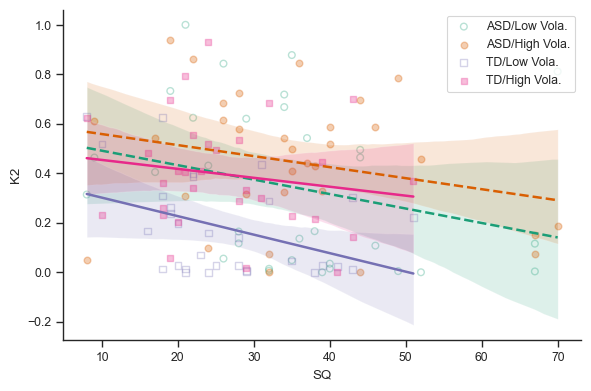

In [55]:
# scatterplot for K2 as a function of SQ, separated by group (different colors), Volatility (different symbols)
#sns.scatterplot(data=res, x='SQ', y='K2', hue='group', style='Volatility', alpha=0.5)
palette = sns.color_palette('Dark2')
plt.figure(figsize=(6,4))
# subplot 1
#plt.subplot(1,2,1)
plt.xlabel('SQ')
plt.ylabel('K2')
# now add regression lines for each group, Volatility
sns.regplot(data=res.query("group == 'ASD' and Volatility == 'Low Vola.'"), 
            x='SQ', y='K2', color = palette[0],  line_kws={'ls':'--'}, 
            scatter_kws ={'facecolors':'none','alpha':0.3}, marker='o', label = "ASD/Low Vola.") 
sns.regplot(data=res.query("group == 'ASD' and Volatility == 'High Vola.'"),
             x='SQ', y='K2', color = palette[1],  line_kws={'ls':'--'}, 
             scatter_kws ={'alpha':0.3}, marker='o', label = "ASD/High Vola.")
sns.regplot(data=res.query("group == 'TD' and Volatility == 'Low Vola.'"), 
            x='SQ', y='K2', color = palette[2], line_kws={'ls':'-'}, 
            scatter_kws ={'facecolors':'none','alpha':0.3}, marker = 's', label = "TD/Low Vola.")
sns.regplot(data=res.query("group == 'TD' and Volatility == 'High Vola.'"), 
            x='SQ', y='K2', color = palette[3],  line_kws={'ls':'-'}, 
            scatter_kws ={'alpha':0.3}, marker='s', label="TD/High Vola.")
# add legend
plt.legend()
# plot a label 'a' on the top left corner
#plt.text(-0.1, 1.1, 'a', transform=plt.gca().transAxes, 
#                            fontsize=16, fontweight='bold', va='top', ha='right')
# remove box around the plot
sns.despine()
# subplot 1
#plt.subplot(1,2,2)
#plt.xlabel('E-S')
#plt.ylabel('K2')
# now add regression lines for each group, Volatility
#sns.regplot(data=res.query("group == 'ASD' and Volatility == 'Low Vola.'"), 
#            x='ES', y='K2', color = palette[0], line_kws={'ls':'--'}, 
#            scatter_kws ={'facecolors':'none','alpha':0.3}, marker='o', label = "ASD/Low Vola.") 
#sns.regplot(data=res.query("group == 'ASD' and Volatility == 'High Vola.'"),
#             x='ES', y='K2', color = palette[1],  line_kws={'ls':'--'}, 
#             scatter_kws ={'alpha':0.3}, marker='o', label = "ASD/High Vola.")
#sns.regplot(data=res.query("group == 'TD' and Volatility == 'Low Vola.'"), 
#            x='ES', y='K2', color = palette[2], line_kws={'ls':'-'}, 
#            scatter_kws ={'facecolors':'none','alpha':0.3}, marker = 's', label = "TD/Low Vola.")
#sns.regplot(data=res.query("group == 'TD' and Volatility == 'High Vola.'"), 
#            x='ES', y='K2', color = palette[3],  line_kws={'ls':'-'}, 
#            scatter_kws ={'alpha':0.3}, marker='s', label="TD/High Vola.")
# add legend
#plt.legend()
# plot a label 'b' on the top left corner
#plt.text(-0.1, 1.1, 'b', transform=plt.gca().transAxes, 
#                            fontsize=16, fontweight='bold', va='top', ha='right')
# remove box around the plot
sns.despine()
# tight layout
plt.tight_layout()
# save the figure to vector file ./figures/K2_vs_SQ.pdf
plt.savefig('./figures/K2_vs_SQ.png', dpi=300)


In [56]:
display(HTML(smf.mixedlm("K1 ~ BDI + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("K2 ~ BDI + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("tau ~ BDI + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("cti ~ BDI + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [57]:
display(HTML(smf.mixedlm("K1 ~ ES + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("K2 ~ ES + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("tau ~ ES + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))
display(HTML(smf.mixedlm("cti ~ ES + group + Volatility", res, groups=res["sub"]).fit().summary().as_html()))


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/strongway/miniforge3/envs/py312/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


ES had a significant correlation with K2. Let's visualize it. 

In [58]:
# show those outliers SQ scores
res.query("sequence in @outliers_regress")[['sub', 'sequence', 'SQ']]

sub  sequence  SQ
2       A32        32  44
3       A32        32  44
12      C32        32  10
13      C32        32  10
36   aril02         2   8
37   aril02         2   8
50    arm13        13  32
51    arm13        13  32
114   crs02         2  21
115   crs02         2  21
124   crw13        13  51
125   crw13        13  51